In [18]:
#Nessesary libs
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications import EfficientNetV2B0

target_shape = (200, 200)

In [19]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"
cache_dir

PosixPath('/home/bartlomiej/.keras')

In [20]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

Downloading...
From (uriginal): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
From (redirected): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34&confirm=t&uuid=0ea1dc5f-3cfd-49de-b1b4-8b03fee2e233
To: /home/bartlomiej/PycharmProjects/pythonProject/left.zip
100%|████████████████████████████████████████| 104M/104M [00:03<00:00, 30.1MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
From (redirected): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW&confirm=t&uuid=6e85f383-2078-497d-ad9b-bcd9f84011b5
To: /home/bartlomiej/PycharmProjects/pythonProject/right.zip
100%|████████████████████████████████████████| 104M/104M [00:04<00:00, 25.0MB/s]


In [21]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_pair(pair, label):
    return ((
        preprocess_image(pair[0]),
        preprocess_image(pair[1]),
    ),label)

In [22]:
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)


anchors = anchor_images * 3
negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)
labels  = tf.constant([1]*6016 + [0]*12032)

comps = positive_images + negative_images

#input_imgs = tf.stack([img_1, img_2], axis=0)
dataset = tf.data.Dataset.from_tensor_slices(((anchors, comps), labels))
dataset = dataset.shuffle(buffer_size=20000)
dataset = dataset.map(preprocess_pair)

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(8, drop_remainder=False)
# train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(8, drop_remainder=False)
# val_dataset = val_dataset.prefetch(8)

In [23]:

import matplotlib.pyplot as plt
ex = next(dataset.batch(60).as_numpy_iterator())
# ex = next(dataset.random(60).as_numpy_iterator())

[1 1 1 0 0]


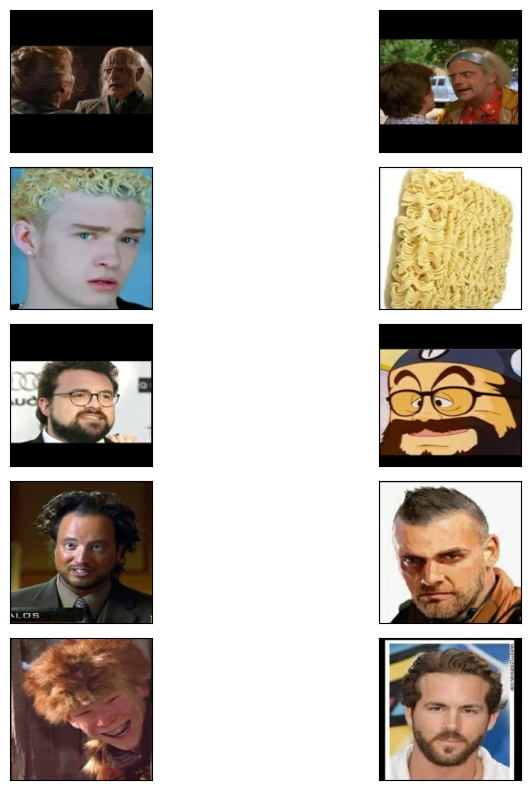

In [24]:
ex0 = ex[0][0]
ex1 = ex[0][1]

print(ex[1][:5])
fig, axes = plt.subplots(5, 2, figsize=(10, 8))
# Iterate through subplots and display images
for i, ax in enumerate(axes):
    ax[0].imshow(ex0[i])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].imshow(ex1[i])
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
plt.tight_layout()
# plt.show()

# Architektura

In [25]:
from keras.layers import Dense, Concatenate, Reshape, Input, Conv2D, ReLU, BatchNormalization, GlobalAveragePooling2D
from keras.applications import EfficientNetV2B3
from keras.utils import plot_model
transfer_layer_size = 1000

base_cnn = EfficientNetV2B3(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)
# for layer in base_cnn.layers:
#     layer.trainable = False
flatten = layers.Flatten()(base_cnn.output)
# dense1 = layers.Dense(1024, activation="relu")(flatten)
# dense1 = layers.BatchNormalization()(dense1)
# dense2 = layers.Dense(1024, activation="relu")(dense1)
# dense2 = layers.BatchNormalization()(dense2)
# output = layers.Dense(transfer_layer_size)(dense2)
output = layers.Dense(transfer_layer_size, activation='relu')(flatten)


embedding = Model(inputs = base_cnn.input, outputs = output, name="Embedding")
# embedding.summary()
# plot_model(embedding, 'model.png')


img_input_1 = Input(target_shape + (3,), name="input_image_1")
img_input_2 = Input(target_shape + (3,), name="input_image_2")

feature_vector_A = embedding(img_input_1)
feature_vector_B = embedding(img_input_2)

joint_vector = Concatenate()([feature_vector_A, feature_vector_B])
siamese_dense_1 = Dense(transfer_layer_size*2, activation='relu', name='siamese_dense_1')(joint_vector)

base_density = 50

siamese_dense_2 = Dense(base_density*2*4*2, activation='relu', name='siamese_dense_2')(siamese_dense_1)
siamese_dense_3 = Dense(base_density*2*4, activation='relu', name='siamese_dense_3')(siamese_dense_2)
siamese_dense_4 = Dense(base_density*2, activation='relu', name='siamese_dense_4')(siamese_dense_3)
siamese_dense_5 = Dense(base_density, activation='relu', name='siamese_dense_5')(siamese_dense_4)
siamese_output = Dense(1, activation='sigmoid', name='siamese_output')(siamese_dense_5)

model = Model(inputs = [img_input_1, img_input_2], outputs = siamese_output)
# model.summary()
# plot_model(model, 'syjam.png')

52606240/52606240 [==============================] - 2s 0us/step


# FIT

In [26]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','mean_squared_error']) # 0.001 -> 0.001 binary_crossentropy ->mean_absolute_error
from keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3)

In [27]:
def loss_fn(output, expected_output):
    return 1
def train_data_selection(train_data, _model):
    ratio = 0.4
    model_output = []
    for dp in train_data:
        model_output = _model.evaluate(dp[0])
    data_loss = [loss_fn(model_out, dp[1]) for (model_out, dp) in zip(model_output, train_data)]

    # posortować dataset po data_loss, nastepnie wziąc subset wynoszący ratio całego zbioru



In [28]:
model.fit(train_dataset, epochs=40, validation_data=val_dataset, callbacks=[es])

Epoch 1/40


2023-06-18 16:20:56.132220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/Embedding/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-18 16:20:59.258871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-06-18 16:20:59.379561: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-18 16:20:59.660880: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1b78f310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-18 16:20:59.660903: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2023-06-18 16:20:59.663769: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash repro

602/602 [==============================] - 252s 357ms/step - loss: 0.6611 - accuracy: 0.3383 - mean_squared_error: 0.6611 - val_loss: 0.6682 - val_accuracy: 0.3318 - val_mean_squared_error: 0.6682
Epoch 2/40
602/602 [==============================] - 211s 350ms/step - loss: 0.6730 - accuracy: 0.3270 - mean_squared_error: 0.6730 - val_loss: 0.6652 - val_accuracy: 0.3348 - val_mean_squared_error: 0.6652
Epoch 3/40
602/602 [==============================] - 218s 363ms/step - loss: 0.6703 - accuracy: 0.3297 - mean_squared_error: 0.6703 - val_loss: 0.6700 - val_accuracy: 0.3300 - val_mean_squared_error: 0.6700
Epoch 4/40
602/602 [==============================] - 222s 368ms/step - loss: 0.6645 - accuracy: 0.3355 - mean_squared_error: 0.6645 - val_loss: 0.6674 - val_accuracy: 0.3326 - val_mean_squared_error: 0.6674
Epoch 5/40
602/602 [==============================] - 217s 360ms/step - loss: 0.6549 - accuracy: 0.3451 - mean_squared_error: 0.6549 - val_loss: 0.6682 - val_accuracy: 0.3318 - va

In [29]:
for layer in embedding.layers:
    layer.trainable = True

In [30]:
train_dataset
for dp in train_dataset:
    # print(dp[0][1][0][0].shape)
    o = model.evaluate([dp[0][0], dp[0][1]])
    # print("expected: " + dp[1][0] + ", got: " + o)
    # print(o)

1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - mean_squared_error: 0.0000e+00
